<a href="https://colab.research.google.com/github/tanay8690/5th_workshop_MachineLearning/blob/main/Psi4%2BTorchANI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ParametrizANI - Dihedral Parametrization in the Cloud with TorchANI**

This is a Jupyter notebook to set up a protocol to calculate a reference dihedral potential with Psi4 and TorchANI (structural optimization), a PyTorch-based program for training/inference of ANI (ANAKIN-ME) deep learning models to obtain potential energy surfaces and other physical properties of molecular systems.  TorchANI is open-source and freely available on GitHub: https://github.com/aiqm/torchani.

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to parametrize compounds in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for parametrization!** It is just simple parametrization pipeline illustrating each step of a protocol.

---
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/ParametrizANI/issues

**Acknowledgments**
- We would like to thank the [Psi4](https://psicode.org/) team for developing an excellent and open source suite of ab initio quantum chemistry.

- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).

- We would like to thank the [Xavier Barril](http://www.ub.edu/bl/) team for their protocol on dihedrals parametrization and for the genetic algorithm script.

- We would like to thank [iwatobipen](https://twitter.com/iwatobipen) for his fantastic [blog](https://iwatobipen.wordpress.com/) on chemoinformatics.

- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.


- Finally, we would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work.

- For related notebooks see: https://github.com/pablo-arantes/ParametrizANI

# **Overview:**

**1.** Create the conformers for each dihedral angle.

**2.** Perform structural optimization, of each conformer, with TorchANI.

**3.** Calculate reference curve with Psi4.

# **Setting the environment for the calculation**

Firstly, we need to install all necessary libraries and packages for our protocol. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    Psi4 (https://psicode.org/)
3.    RDKit (https://www.rdkit.org/)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    TorchANI (https://aiqm.github.io/torchani/)

In [1]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:24
🔁 Restarting kernel...


In [1]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
import subprocess
import sys
subprocess.run("rm -rf /usr/local/conda-meta/pinned", shell=True)
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("mamba install -c anaconda intel-openmp", shell=True)
subprocess.run("mamba install -c psi4 psi4 resp", shell=True)
subprocess.run("mamba install pytorch torchvision -c pytorch", shell=True)
subprocess.run("pip install torchani", shell=True)
subprocess.run("pip install ase", shell=True)
subprocess.run("pip install rdkit-pypi", shell=True)
subprocess.run("mamba install -c conda-forge debtcollector", shell=True)
subprocess.run("pip install git+https://github.com/pablo-arantes/psikit", shell=True)
subprocess.run("mamba install -c conda-forge openbabel -y", shell=True)

CompletedProcess(args='mamba install -c conda-forge openbabel -y', returncode=0)

Smiles: CC(C1=CC=CC=C1)=O


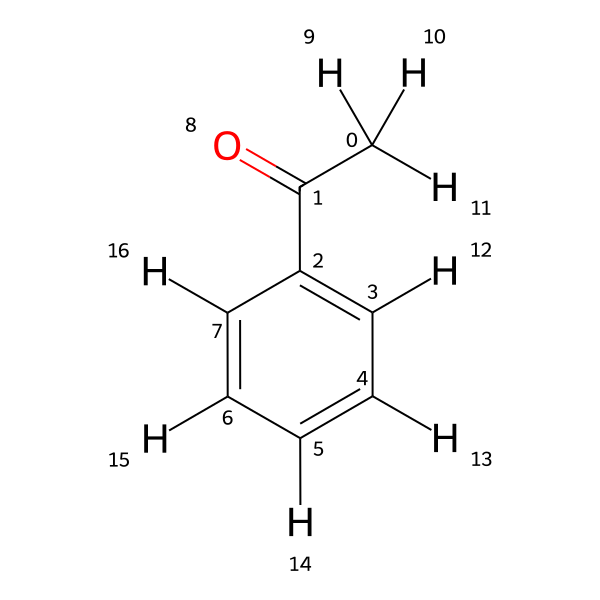

In [2]:
#@title **Please, provide the necessary information for the molecule**:

#@markdown Type the smiles or filename (PDB and MOL formats) of your molecule. **Ex: C=CC(=O)OC, molecule.pdb or molecule.mol**

#@markdown Just remind you that if you want to use pdb or mol file, you should first upload the file here in Colab.

#@markdown If you don't know the exactly smiles, please, check at https://pubchem.ncbi.nlm.nih.gov/
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from openbabel import pybel
import os

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

import py3Dmol


workDir = "/content/"
Type = "smiles" #@param ["smiles", "pdb", "mol"]

smiles_or_filename = 'CC(C1=CC=CC=C1)=O' #@param {type:"string"}

if Type == "smiles":
  Smiles = smiles_or_filename
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
elif Type == "pdb":
  mol= [m for m in pybel.readfile(filename=smiles_or_filename, format='pdb')][0]
  out=pybel.Outputfile(filename='mol.mol',format='mol',overwrite=True)
  out.write(mol)
  out.close()
  mol = Chem.MolFromMolFile('mol.mol')
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
else:
  mol = Chem.MolFromMolFile(smiles_or_filename)
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)


d2d = rdMolDraw2D.MolDraw2DSVG(600, 600)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(hmol)
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
with open('smiles.svg', 'w') as f:
    f.write(svg)
print("Smiles: " + str(Smiles))
SVG(svg)

In [3]:
#@title ### **Set your dihedral angle**
#@markdown Type the number of atoms for your dihedral angle.
#@markdown The dihedral angle we will perform the dihedral scan will be defined by these atoms.
from termcolor import colored

atom1 = '6' #@param {type:"string"}
atom2 = '7' #@param {type:"string"}
atom3 = '8' #@param {type:"string"}
atom4 = '9' #@param {type:"string"}

#@markdown Select step size in degrees for the dihedral angle rotation:
degrees_steps = "60" #@param ["10", "15", "20", "30", "45", "60"]
with open('degrees.dat', 'w') as f:
  f.write(degrees_steps)

optimization = "ANI" #@param ["ANI", "MMFF94"]

if optimization == "MMFF94":
  mol = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(hmol)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  AllChem.OptimizeMolecule(ff, maxIters=1000)
  ff.Minimize()
  charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Chem.GetFormalCharge(hmol)
  print("Charge = " + str(charge))
  if not charge == 0:
    print(colored("ANI cannot do charged system yet, stay tuned!", 'red'))
    exit()
  else:
    pass
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)
else:
  from typing import List
  from ase import Atoms
  from ase.lattice.cubic import Diamond
  from ase.md.langevin import Langevin
  from ase.optimize import BFGS
  from ase import io
  from ase.io import read, write
  from ase import units
  from ase.constraints import ExternalForce, FixInternals
  import torch
  import torchani
  import pandas as pd
  import numpy as np
  from torchani.units import HARTREE_TO_KCALMOL
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")


  def mol2arr(mols, device=device):
      coordinates = []
      spices = []
      for mol in mols:
          pos = mol.GetConformer().GetPositions().tolist()
          atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
          coordinates.append(pos)
          spices.append(atomnums)
      coordinates = torch.tensor(coordinates, requires_grad=True, device=device)
      species = torch.tensor(spices, device=device)
      return coordinates, species

  mol = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(hmol)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  AllChem.OptimizeMolecule(ff, maxIters=1000)
  ff.Minimize()
  charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Chem.GetFormalCharge(hmol)
  print("Charge = " + str(charge))
  if not charge == 0:
    print(colored("ANI cannot do charged system yet, stay tuned!", 'red'))
    exit()
  else:
    pass
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"start.mol")))
  mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, f"start.mol")), removeHs=False)
  mol = io.read(os.path.join(workDir, f"start.mol"))
  coordinates, species = mol2arr([mol_deg], device)
  tensor1 = coordinates.detach().numpy()
  atoms = Atoms(mol, positions=tensor1[0])
  atoms.center(vacuum=3.0)
  atoms.set_calculator(calculator)
  print("Begin minimizing ")
  opt = BFGS(atoms)
  opt.run(fmax=0.0001)
  write((os.path.join(workDir, f"start_min.xyz")), format="xyz", images=atoms)

  atomic_symbols = []
  xyz_coordinates = []

  with open((os.path.join(workDir, f"start_min.xyz")), "r") as file:
    for line_number,line in enumerate(file):
      if line_number == 0:
        num_atoms = int(line)
      elif line_number == 1:
        comment = line # might have useful information
      else:
        atomic_symbol, x, y, z = line.split()
        atomic_symbols.append(atomic_symbol)
        xyz_coordinates.append([float(x),float(y),float(z)])

  from rdkit.Geometry import Point3D
  conf = mol_deg.GetConformer()

  for i in range(mol_deg.GetNumAtoms()):
    x,y,z = xyz_coordinates[i]
    conf.SetAtomPosition(i,Point3D(x,y,z))
  AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, f"start_min.mol")))


  hmol = AllChem.MolFromMolFile ((os.path.join(workDir, f"start_min.mol")), removeHs=False)
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)

/usr/local/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


/usr/local/lib/python3.11/site-packages/torchani/resources/
/usr/local/lib/python3.11/site-packages/torchani/resources/
Model = ANI2x
Charge = 0
Begin minimizing 
      Step     Time          Energy          fmax
BFGS:    0 17:12:23   -10470.680003        1.251709
BFGS:    1 17:12:23   -10470.680649        1.637936
BFGS:    2 17:12:24   -10470.697870        0.193045
BFGS:    3 17:12:24   -10470.700684        0.160744
BFGS:    4 17:12:24   -10470.705551        0.149601


<ipython-input-3-a4362c2e9f6c>:92: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(calculator)


BFGS:    5 17:12:24   -10470.706678        0.078587
BFGS:    6 17:12:24   -10470.707286        0.050925
BFGS:    7 17:12:24   -10470.707570        0.038169
BFGS:    8 17:12:24   -10470.707734        0.028431
BFGS:    9 17:12:24   -10470.707887        0.034009
BFGS:   10 17:12:24   -10470.708000        0.032167
BFGS:   11 17:12:24   -10470.708057        0.022064
BFGS:   12 17:12:24   -10470.708087        0.010696
BFGS:   13 17:12:24   -10470.708104        0.011156
BFGS:   14 17:12:24   -10470.708113        0.006484
BFGS:   15 17:12:24   -10470.708116        0.005046
BFGS:   16 17:12:24   -10470.708120        0.007841
BFGS:   17 17:12:24   -10470.708125        0.009577
BFGS:   18 17:12:24   -10470.708129        0.006209
BFGS:   19 17:12:24   -10470.708129        0.004014
BFGS:   20 17:12:24   -10470.708131        0.003766
BFGS:   21 17:12:24   -10470.708134        0.003629
BFGS:   22 17:12:24   -10470.708132        0.003794
BFGS:   23 17:12:24   -10470.708135        0.001901
BFGS:   24 1

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title ### **Create the conformers based on your dihedral angle**
#@markdown Run this cell to create the conformers based on your selections from previous cell. To do so, we will rotate the dihedral from -180 to 180 degrees (with a step size chosen in the previous cell).

#@markdown **Important**: The output will show just a few conformers, not all of them. If you check the **mol_files** folder, all of your conformers will be there.


#Create the conformers and save in the folder
import glob
import copy
import numpy as np
from IPython.display import display

if os.path.exists(os.path.join(workDir, "mol_files")):
  for f in glob.glob(os.path.join(workDir, "mol_files/*.mol")):
    os.remove(f)
else:
  os.mkdir(os.path.join(workDir, "mol_files"))

confs = []
filenames = []

if optimization == "ANI":
  hmol = AllChem.MolFromMolFile ((os.path.join(workDir, f"start_min.mol")), removeHs=False)
else:
  pass

for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
    rdMolTransforms.SetDihedralDeg(hmol.GetConformer(0), int(atom1), int(atom2), int(atom3), int(atom4), deg)
    mp = AllChem.MMFFGetMoleculeProperties(hmol)
    ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
    ff.MMFFAddTorsionConstraint(int(atom1), int(atom2), int(atom3), int(atom4), False, deg, deg, 1000.0,)
    # for a in hmol.GetAtoms():
    #     if (a.GetAtomicNum() > 1):
    #         ff.MMFFAddPositionConstraint(a.GetIdx(), 0.0, 1.e4)
    AllChem.OptimizeMolecule(ff, maxIters=200)
    ff.Minimize(maxIts=1000)
    AllChem.MolToMolFile(hmol, (os.path.join(workDir, "mol_files/" + str(deg) + ".mol")))
    if deg % 90 == 0:
        print(deg)
        display(IPythonConsole.drawMol3D(hmol))

-180


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

180


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

In [ ]:
#@title **Geometry optimization of conformers with TorchANI**:

#@markdown Please, select your ANI model:
model_name = "ANI-2x" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x"]

#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.0001 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}

from typing import List
from ase import Atoms
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.optimize import BFGS
from ase import io
from ase.io import read, write
from ase import units
from ase.constraints import ExternalForce, FixInternals
from ase.calculators.psi4 import Psi4
from ase.build import molecule
import torch
import torchani
import pandas as pd
import numpy as np
from torchani.units import HARTREE_TO_KCALMOL

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

if model_name == "ANI-2x":
  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")
elif model_name == "ANI-1ccx":
  model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1ccx().ase()
  print("Model = ANI1ccx")
elif model_name == "ANI-1x":
  model = torchani.models.ANI1x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1x().ase()
  print("Model = ANI1x")
else:
  pass

def mol2arr(mols, device=device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates,
                               requires_grad=True,
                               device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species


for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "mol_files/" + str(deg) + ".mol")), removeHs=False)
  mol = io.read(os.path.join(workDir, "mol_files/" + str(deg) + ".mol"))
  coordinates, species = mol2arr([mol_deg], device)
  tensor1 = coordinates.detach().numpy()
  atoms = Atoms(mol, positions=tensor1[0])
  atoms.center(vacuum=3.0)
  dihedral_indices1 = [int(atom1), int(atom2), int(atom3), int(atom4)]
  dihedral1 = [atoms.get_dihedral(*dihedral_indices1), dihedral_indices1]
  c = FixInternals(dihedrals_deg=[dihedral1])
  atoms.set_constraint(c)
  atoms.set_calculator(calculator)
  print("Begin minimizing " + str(deg) + ".mol" )
  opt = BFGS(atoms)
  opt.run(fmax=opt_tol)
  write((os.path.join(workDir, "mol_files/" + str(deg) + "_min.xyz")), format="xyz", images=atoms)

  atomic_symbols = []
  xyz_coordinates = []

  with open((os.path.join(workDir, "mol_files/" + str(deg) + "_min.xyz")), "r") as file:
    for line_number,line in enumerate(file):
        if line_number == 0:
            num_atoms = int(line)
        elif line_number == 1:
            comment = line # might have useful information
        else:
            atomic_symbol, x, y, z = line.split()
            atomic_symbols.append(atomic_symbol)
            xyz_coordinates.append([float(x),float(y),float(z)])

  from rdkit.Geometry import Point3D
  conf = mol_deg.GetConformer()

  for i in range(mol_deg.GetNumAtoms()):
    x,y,z = xyz_coordinates[i]
    conf.SetAtomPosition(i,Point3D(x,y,z))
  AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, "mol_files/" + str(deg) + "_min.mol")))
  AllChem.MolToPDBFile(mol_deg, (os.path.join(workDir, "mol_files/" + str(deg) + "_min.pdb")))

/usr/local/lib/python3.10/site-packages/torchani/resources/
/usr/local/lib/python3.10/site-packages/torchani/resources/
Model = ANI2x
Begin minimizing -180.mol
      Step     Time          Energy          fmax
BFGS:    0 23:28:07   -17792.112096        1.234954
BFGS:    1 23:28:07   -17792.127535        1.220969
BFGS:    2 23:28:07   -17792.142094        0.278116


<ipython-input-6-e3f420b71dbf>:71: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(calculator)


BFGS:    3 23:28:07   -17792.147996        0.195364
BFGS:    4 23:28:07   -17792.154180        0.236380
BFGS:    5 23:28:07   -17792.159159        0.161538
BFGS:    6 23:28:07   -17792.162383        0.145891
BFGS:    7 23:28:07   -17792.164864        0.108378
BFGS:    8 23:28:07   -17792.166302        0.094892
BFGS:    9 23:28:08   -17792.167539        0.081116
BFGS:   10 23:28:08   -17792.168985        0.090129
BFGS:   11 23:28:08   -17792.170267        0.070632
BFGS:   12 23:28:08   -17792.171437        0.089489
BFGS:   13 23:28:08   -17792.172745        0.083989
BFGS:   14 23:28:08   -17792.173868        0.060022
BFGS:   15 23:28:08   -17792.174739        0.064239
BFGS:   16 23:28:08   -17792.175577        0.073888
BFGS:   17 23:28:08   -17792.176769        0.088669
BFGS:   18 23:28:08   -17792.178315        0.093772
BFGS:   19 23:28:08   -17792.179723        0.093865
BFGS:   20 23:28:08   -17792.180803        0.086679
BFGS:   21 23:28:08   -17792.181769        0.077840
BFGS:   22 2

In [ ]:
#@title **Dihedral scan energy profile with Psi4**:

#@markdown Please, select your method and basis set:

method = "HF" #@param ["B3LYP", "MP2", "HF"]

basisSet = "6-31G*" #@param ["STO-3g", "3-21G", "6-31G*", "6-31G**", "6-31+G(d,p)", "6-311++G(2d,p)"]

from psikit import Psikit
pk = Psikit()


def B3LYP_basis (basis_Set):
    vals = {"STO-3g" : "b3lyp/STO-3g"  ,  "3-21G" : "b3lyp/3-21G", "6-31G*" : "b3lyp/6-31g*", "6-31G**" : "b3lyp/6-31g**", "6-31+G(d,p)" : "b3lyp/6-31+G(d,p)", "6-311++G(2d,p)" : "b3lyp/6-311++G(2d,p)" }
    return vals[basis_Set]

def MP2_basis (basis_Set):
    vals = {"STO-3g" : "mp2/STO-3g"  ,  "3-21G" : "mp2/3-21G", "6-31G*" : "mp2/6-31g*", "6-31G**" : "mp2/6-31g**", "6-31+G(d,p)" : "mp2/6-31+G(d,p)", "6-311++G(2d,p)" : "mp2/6-311++G(2d,p)" }
    return vals[basis_Set]

def HF_basis (basis_Set):
    vals = {"STO-3g" : "hf/STO-3g"  ,  "3-21G" : "hf/3-21G", "6-31G*" : "hf/6-31g*", "6-31G**" : "hf/6-31g**", "6-31+G(d,p)" : "hf/6-31+G(d,p)", "6-311++G(2d,p)" : "hf/6-311++G(2d,p)" }
    return vals[basis_Set]

if method == "B3LYP":
  basis_set_psi4 = B3LYP_basis(basisSet)
elif method == "MP2":
  basis_set_psi4 = MP2_basis(basisSet)
elif method == "HF":
  basis_set_psi4 = HF_basis(basisSet)
else:
  pass

print("Degrees    Energy")

dihedral_energies = []
dihe_degree = []
for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  pk.read_from_molfile(os.path.join(workDir, "mol_files/" + str(deg) + "_min.mol"), opt=False)
  degy = pk.energy(basis_sets=basis_set_psi4)
  print(deg, degy)
  dihedral_energies.append(degy)
  dihe_degree.append(deg)

dihedral_energies_array = np.array(dihedral_energies)
relative = (dihedral_energies_array - dihedral_energies_array.min()) * pk.psi4.constants.hartree2kcalmol

#Save dat file
with open(str(method) + "_" + str(basisSet) + '.dat', 'w') as f:
    for deg, item in zip(dihe_degree, relative):
      degree_str = str("{:.3f}".format(deg))
      energy_str = str("{:.3f}".format(item))
      f.write(str(deg) + " " + str(item) + "\n")
      # f.write("%s\n" % item)

Degrees    Energy
-180 -649.8643604182632
-150 -649.8663995642669
-120 -649.8639167942058
-90 -649.8592778644612
-60 -649.863862568287
-30 -649.8688952875519
0 -649.8701339895263
30 -649.8688965586875
60 -649.8638589503801
90 -649.8592773350605
120 -649.8639119876074
150 -649.8663970751355
180 -649.864362235355


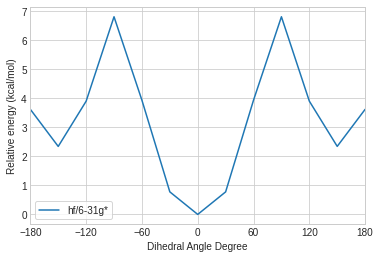

In [ ]:
#@title **Check the profile calculated with Psi4**:

#@markdown y-axis with energy in kcal/mol and x-axis with dihedral angle degrees.

import numpy as np
dihedral_energies_array = np.array(dihedral_energies)

relative = (dihedral_energies_array - dihedral_energies_array.min()) * pk.psi4.constants.hartree2kcalmol
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.plot(dihe_degree, relative, linewidth = 1.5, label = basis_set_psi4)
# ani = pd.read_csv('/content/ani.dat', header=None)
# plt.plot(dihe_degree, ani, linewidth = 1.5, label = "ANI")
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([-180, 180])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
plt.savefig(str(method) + "_" + str(basisSet) + '.png', dpi=600, bbox_inches='tight')

In [ ]:
#@title **Download your results**
from google.colab import files
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

if os.path.exists("dihedral_scan.zip"):
  os.remove("dihedral_scan.zip")
else:
  pass

!zip -FSr "dihedral_scan.zip" "mol_files" "pdb_min" *".pdb" *".png" *."txt" *."dat" *."svg"  >/dev/null 2>&1
files.download('dihedral_scan.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>